# Importaciones y definiciones

In [1]:
# DataFrames
import pandas as pd
# Rutas
import os
from pathlib import Path
# Operaciones y métricas
import numpy as np
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import scipy.stats as stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller, kpss
# Gráficas
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Modelos
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from pmdarima import auto_arima
# Validación cruzada
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Importamos los datos
notebook_path = os.path.abspath('')
current_dir = Path(notebook_path)
# Asegúrate de que esta ruta sea la correcta para tu estructura de carpetas
data_dir = current_dir.parent / 'archivos' / 'archivos_formateados'

ruta_luz = data_dir / 'precio-luz-conformato.csv'
ruta_eolica = data_dir / 'generacion-eolica-conformato.csv'
ruta_solar = data_dir / 'generacion-solar-conformato.csv'
ruta_demanda = data_dir / 'demanda-real-conformato.csv'

precio_luz = pd.read_csv(ruta_luz)
generacion_eolica = pd.read_csv(ruta_eolica)
generacion_solar = pd.read_csv(ruta_solar)
demanda_real = pd.read_csv(ruta_demanda)

Para dar formato a los DataSets hacemos lo siguiente:
- Marcamos una fecha de final por si los datos no acban en el mismo día
- Introducimos un desfase en las varaibles exógenas para evitar el data leaking en el modelo

In [3]:
# Marcamos una fecha de fin por si los conjuntos terminan en días distintos
fecha_fin = pd.to_datetime('2025-06-30T23:00:00+02:00').tz_convert('UTC')

def process_df(df, col, end_date):
    """Procesa los dataframes para asegurar el formato correcto."""
    df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
    df = df.set_index('datetime').asfreq('h')
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df[df[col] > 0]
    return df.loc[:end_date].dropna(subset=[col])

precio_luz = process_df(precio_luz, 'precio', fecha_fin)
generacion_eolica = process_df(generacion_eolica, 'generacion', fecha_fin)
generacion_solar = process_df(generacion_solar, 'generacion', fecha_fin)
demanda_real = process_df(demanda_real, 'demanda', fecha_fin)

# Unimos los dataframes
df = precio_luz[['precio']].copy()
df['generacion_eolica'] = generacion_eolica['generacion'].shift(24)
df['generacion_solar'] = generacion_solar['generacion'].shift(24)
df['demanda_real'] = demanda_real['demanda'].shift(24)
df['hora'] = df.index.hour
df['dia_semana'] = df.index.dayofweek
df['mes'] = df.index.month
df['lag_24'] = df['precio'].shift(24)
df['lag_168'] = df['precio'].shift(168)
# df['rolling_mean_24'] = df['precio'].rolling(24).mean()
# df['rolling_std_24'] = df['precio'].rolling(24).std()
# df['rolling_mean_24_eolica'] = df['generacion_eolica'].rolling(24).mean()
# df['rolling_std_24_eolica'] = df['generacion_eolica'].rolling(24).std()
# df['rolling_mean_24_solar'] = df['generacion_solar'].rolling(24).mean()
# df['rolling_std_24_solar'] = df['generacion_solar'].rolling(24).std()
# df['rolling_mean_24_demanda'] = df['demanda_real'].rolling(24).mean()
# df['rolling_std_24_demanda'] = df['demanda_real'].rolling(24).std()

df.dropna(inplace=True)

y = df['precio']

columnas_exogenas = [
    'generacion_eolica',
    'generacion_solar', 
    'demanda_real',
    'hora', 
    'dia_semana',
    'mes',
    # 'rolling_mean_24', 
    # 'rolling_std_24',
    # 'rolling_mean_24_eolica', 
    # 'rolling_std_24_eolica',
    # 'rolling_mean_24_solar', 
    # 'rolling_std_24_solar',
    # 'rolling_mean_24_demanda', 
    # 'rolling_std_24_demanda',
]
X = df[columnas_exogenas]
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.dropna(inplace=True)
X = X.loc[y.index]

print(df.head(5))

                           precio  generacion_eolica  generacion_solar  \
datetime                                                                 
2023-01-08 12:00:00+00:00     5.0          13935.468       5452.666667   
2023-01-08 13:00:00+00:00     4.6          14552.910       5075.333333   
2023-01-08 14:00:00+00:00     4.2          14716.957       4167.250000   
2023-01-08 15:00:00+00:00     4.6          15290.051       2484.916667   
2023-01-08 16:00:00+00:00     7.1          15442.083        647.666667   

                           demanda_real  hora  dia_semana  mes  lag_24  \
datetime                                                                 
2023-01-08 12:00:00+00:00  26869.833333    12           6    1    8.00   
2023-01-08 13:00:00+00:00  27180.500000    13           6    1    5.46   
2023-01-08 14:00:00+00:00  26282.666667    14           6    1    4.16   
2023-01-08 15:00:00+00:00  25919.416667    15           6    1    8.00   
2023-01-08 16:00:00+00:00  26457.3333

In [4]:
# Fecha donde termina el entrenamiento y empieza el test
fecha_fin_train = '2025-04-30 23:00:00+00:00'
# Fecha donde termina la validación y empieza la predicción final
fecha_fin_test = '2025-05-31 23:00:00+00:00'
# Train set
y_train = y.loc[:fecha_fin_train]
X_train = X.loc[:fecha_fin_train]
# Test set
y_test = y.loc[pd.to_datetime(fecha_fin_train) + pd.Timedelta(hours=1) : fecha_fin_test]
X_test = X.loc[pd.to_datetime(fecha_fin_train) + pd.Timedelta(hours=1) : fecha_fin_test]
y_prediccion_real = y.loc[pd.to_datetime(fecha_fin_test) + pd.Timedelta(hours=1):]
X_prediccion = X.loc[pd.to_datetime(fecha_fin_test) + pd.Timedelta(hours=1):]
print("--- Verificación de Índices ---")
print(f"Train:{y_train.index.min()} -> {y_train.index.max()} (Tamaño: {len(y_train)})")
print(f"Test:{y_test.index.min()} -> {y_test.index.max()} (Tamaño: {len(y_test)})")
print(f"Predicción: {X_prediccion.index.min()} -> {X_prediccion.index.max()} (Tamaño: {len(X_prediccion)})")

--- Verificación de Índices ---
Train:2023-01-08 12:00:00+00:00 -> 2025-04-30 23:00:00+00:00 (Tamaño: 19108)
Test:2025-05-01 00:00:00+00:00 -> 2025-05-31 23:00:00+00:00 (Tamaño: 475)
Predicción: 2025-06-01 00:00:00+00:00 -> 2025-06-30 21:00:00+00:00 (Tamaño: 632)


# Análisis exploratorio

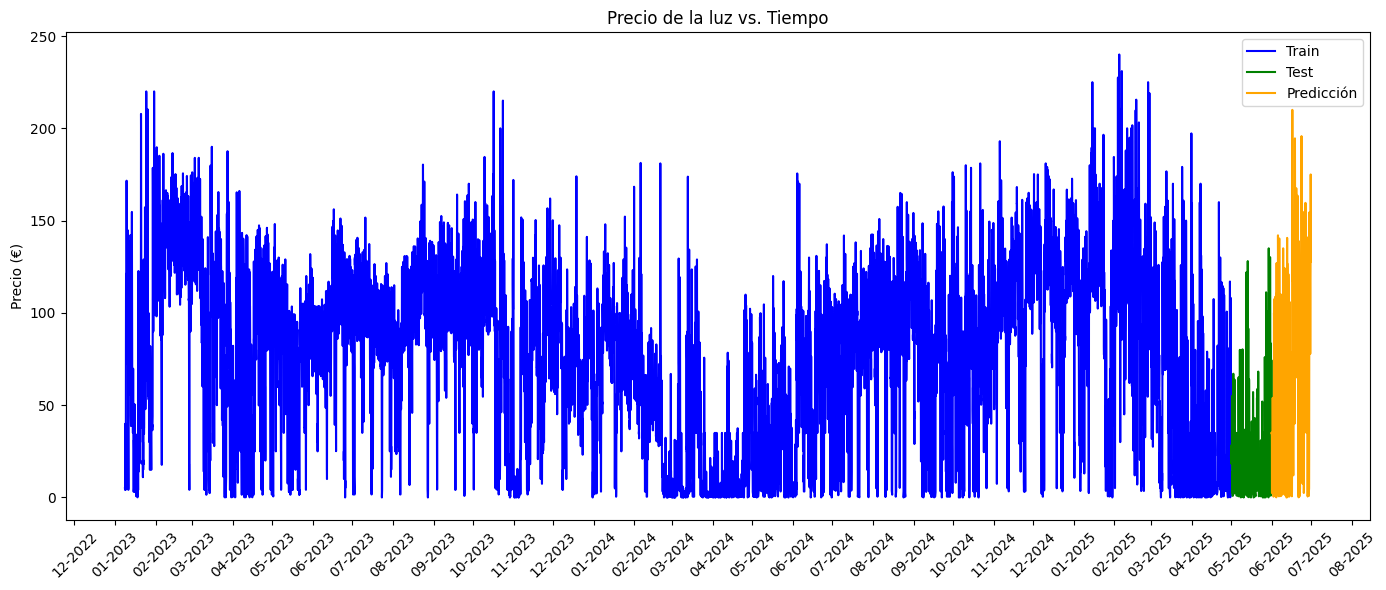

In [5]:
# Graficamos directamente la serie de precios
plt.figure(figsize=(14, 6))

plt.plot(y_train.index, y_train, label='Train', color='blue')
plt.plot(y_test.index, y_test, label='Test', color='green')
plt.plot(y_prediccion_real.index, y_prediccion_real, label='Predicción', color='orange')
plt.title('Precio de la luz vs. Tiempo')
plt.ylabel('Precio (€)')
plt.legend()
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observamos en los boxplots que:
- Las horas valle son al medio día y en los meses de marzo, abril y mayo
- Las horas pico son a primeras horas del día (06:00) y por la tarde (19:00)

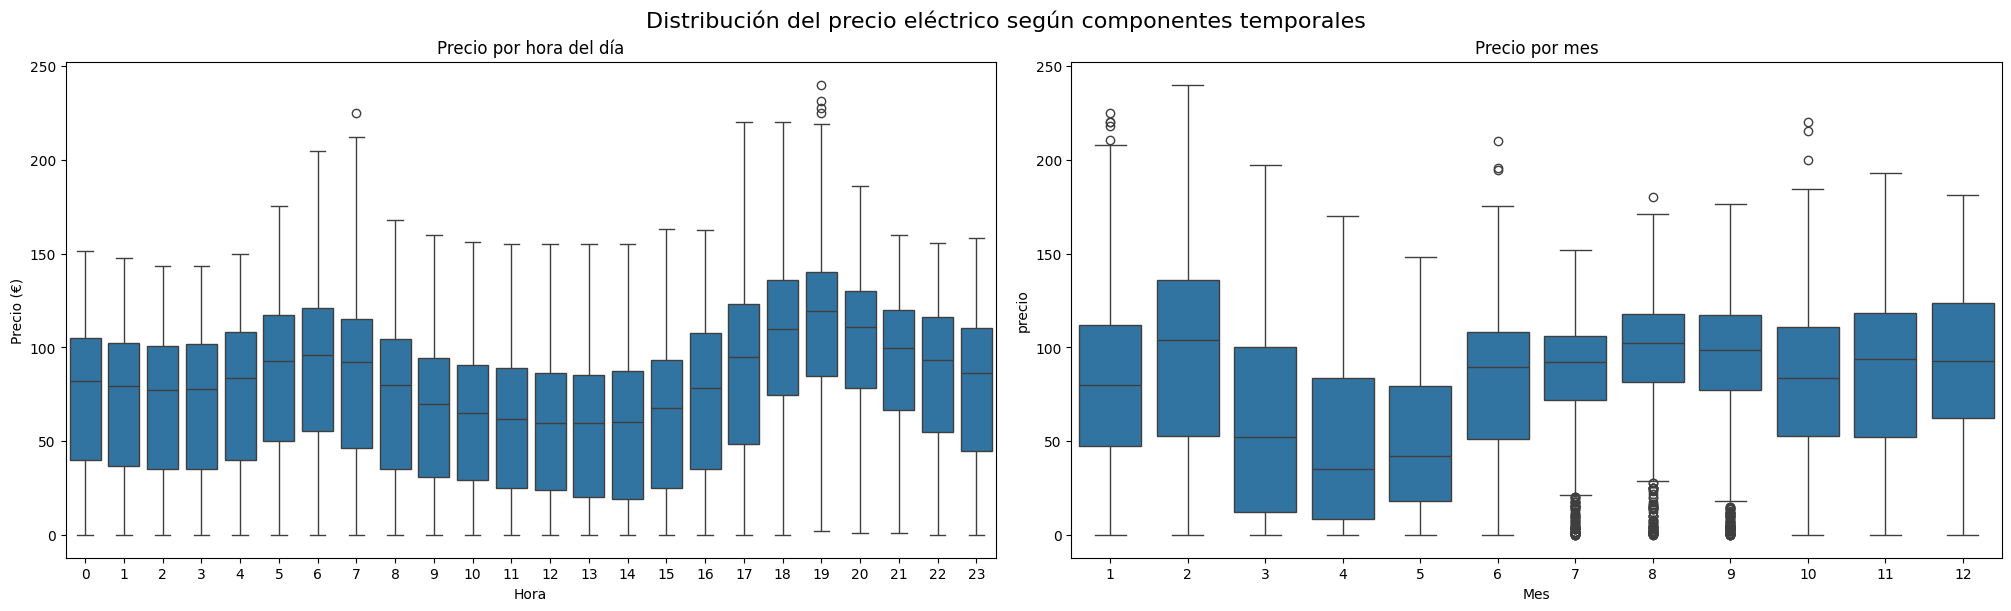

In [6]:
# Boxplots
df['hora'] = df.index.hour
df['dia_semana'] = df.index.dayofweek 
df['mes'] = df.index.month

fig, axes = plt.subplots(1, 2, figsize=(20, 6), constrained_layout=True)

# Boxplot por hora
sns.boxplot(x='hora', y='precio', data=df, ax=axes[0])
axes[0].set_title('Precio por hora del día')
axes[0].set_xlabel('Hora')
axes[0].set_ylabel('Precio (€)')

# Boxplot por mes
sns.boxplot(x='mes', y='precio', data=df, ax=axes[1])
axes[1].set_title('Precio por mes')
axes[1].set_xlabel('Mes')

plt.suptitle('Distribución del precio eléctrico según componentes temporales', fontsize=16)
plt.show()

La matriz de correlación nos muestra la relación entre las variables, en este caso nos interesa ver que tenemos valores intermedios entre la endógena y las exógenas, sin llegar a extremos cercanos a 1.

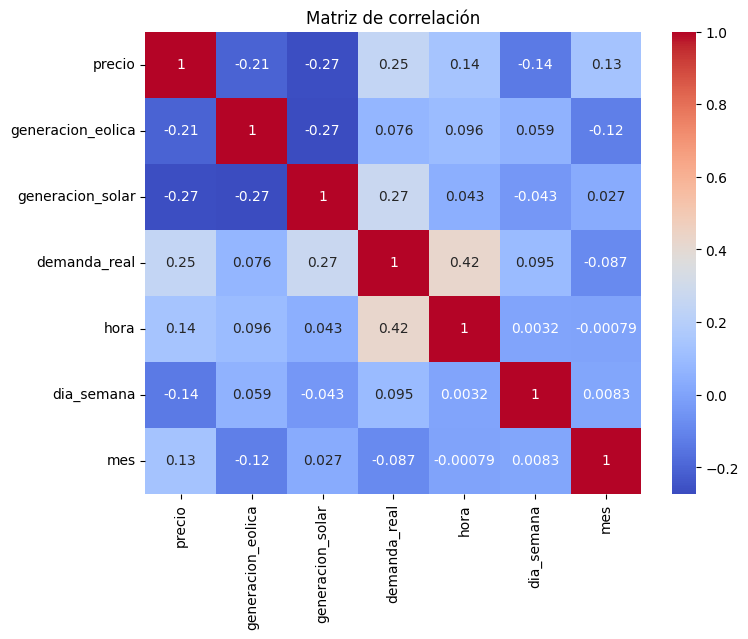

In [7]:
# Matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(df[['precio', 'generacion_eolica', 'generacion_solar', 'demanda_real', 'hora', 'dia_semana', 'mes']].corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()

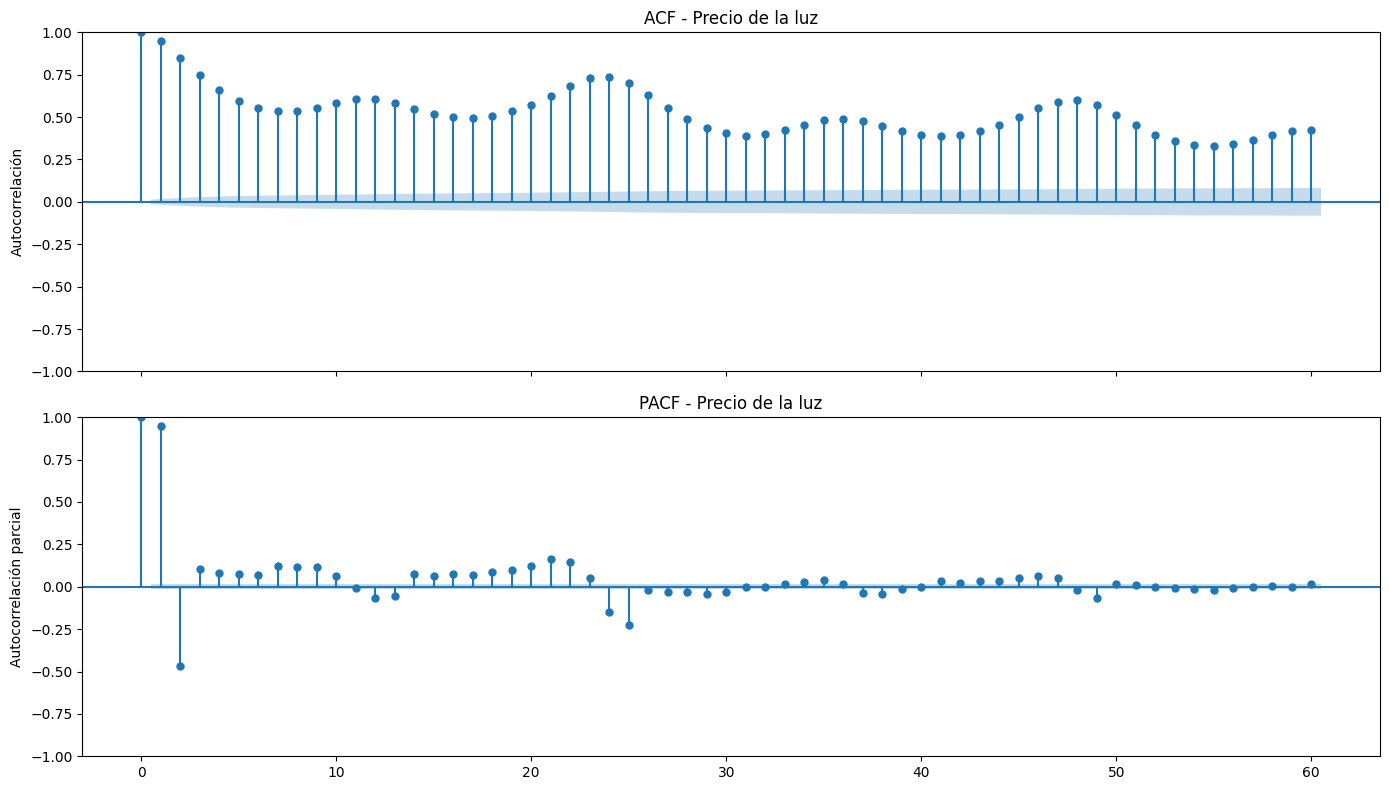

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

plot_acf(df['precio'], lags=60, ax=axes[0])
axes[0].set_title('ACF - Precio de la luz')
axes[0].set_ylabel('Autocorrelación')

plot_pacf(df['precio'], lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF - Precio de la luz')
axes[1].set_ylabel('Autocorrelación parcial')

plt.tight_layout()
plt.show()

# Análisis de la serie temporal

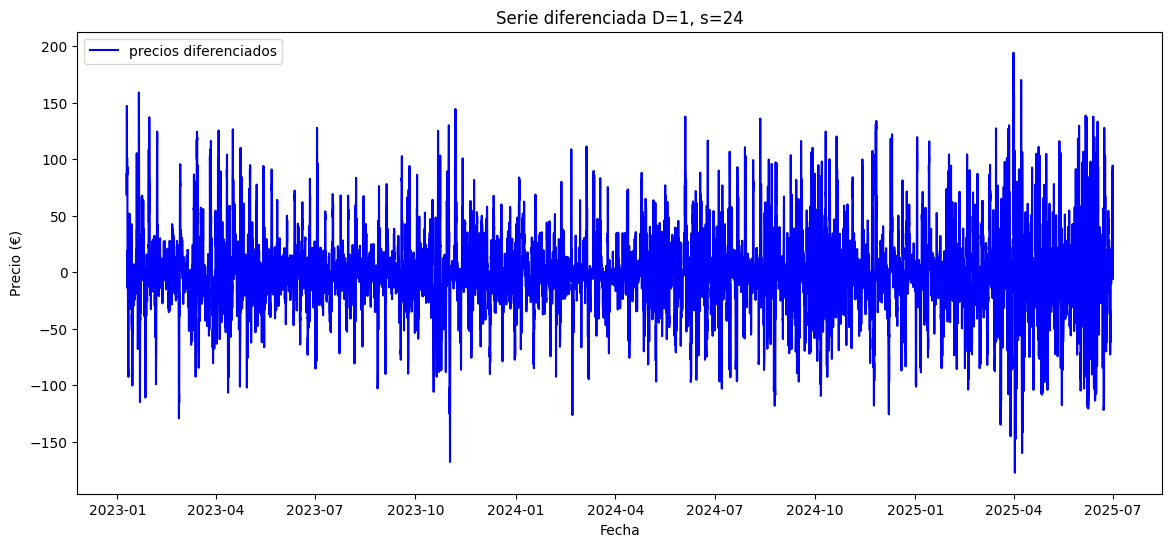

In [9]:
# Una diferenciación estacional D
df_diferenciada = df['precio'].diff(24).dropna()

# Graficamos la serie diferenciada
plt.figure(figsize=(14,6))
plt.plot(df_diferenciada.index, df_diferenciada,label = 'precios diferenciados', color='blue')
plt.title('Serie diferenciada D=1, s=24')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.show()

## Miramos los ACF y PACF de la serie diferenciada D=0 (s=24) y d = 1

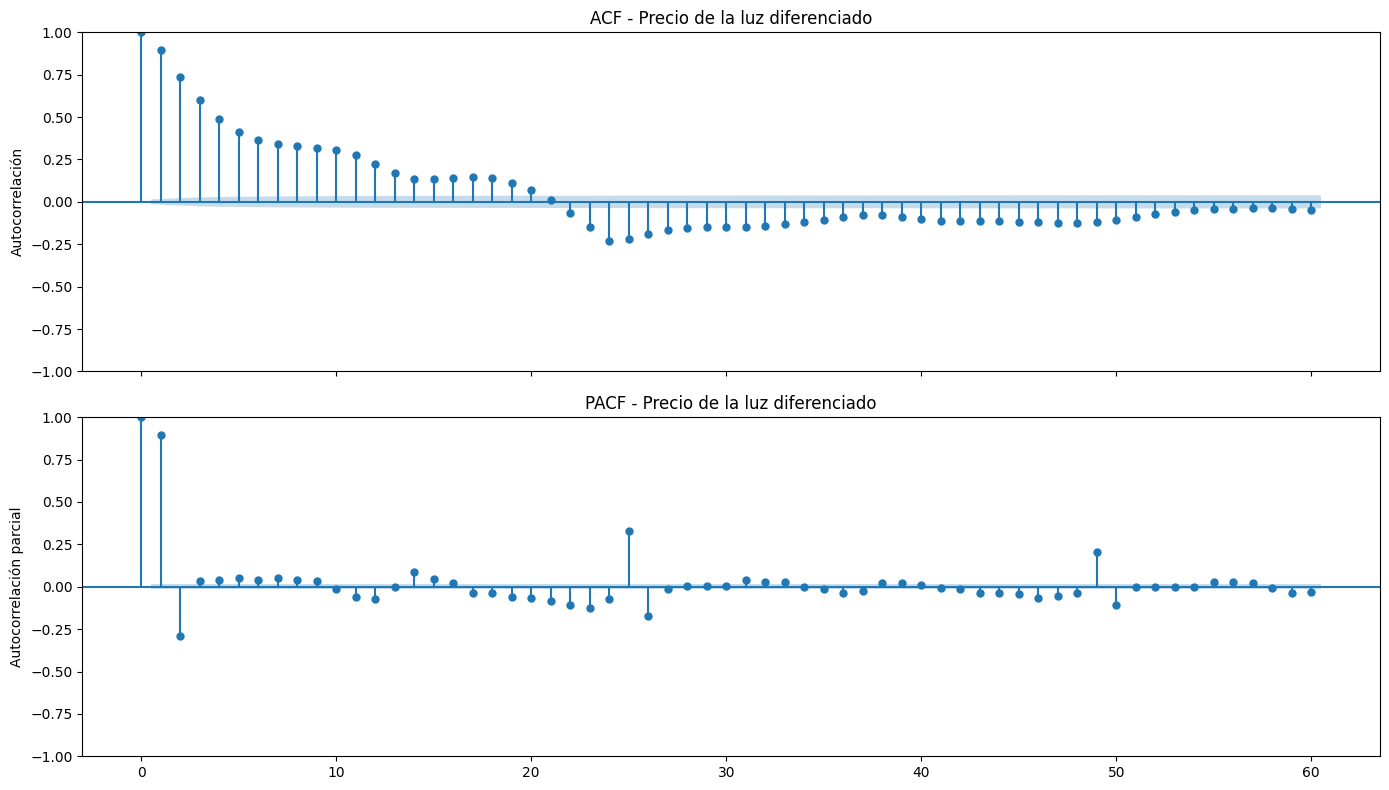

In [10]:
# ACF y PACF de la serie diferenciada
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

plot_acf(df_diferenciada, lags=60, ax=axes[0])
axes[0].set_title('ACF - Precio de la luz diferenciado')
axes[0].set_ylabel('Autocorrelación')

plot_pacf(df_diferenciada, lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF - Precio de la luz diferenciado')
axes[1].set_ylabel('Autocorrelación parcial')

plt.tight_layout()
plt.show()

Realizamos el test ADF y KSS para ver como es la serie

- **ADF:** Lo que contrastamos con este test es

    - La hipótesis nula (`H_0`) es que existe una raíz unitaria y por tanto la serie es **NO** estacionaria. (p-valor > `alpha`) 
    - La hipótesis alternativa (`H_a`) de que la serie **SÍ** es estacionaria. (p-valor < `alpha`) 

- **KSS:** En este caso es al revés:
    - La hipótesis nula (`H_0`) es que la serie **SÍ** es estacionaria. (p-valor > `alpha`) 
    - La hipótesis alternativa (`H_a`) de que la serie **NO** es estacionaria. (p-valor < `alpha`) 

In [11]:
# ADF y KPSS
adf_test = adfuller(df_diferenciada, autolag='AIC')
print(f"ADF p-value: {adf_test[1]}")
kpss_test = kpss(df_diferenciada, regression='c')
print(f"KPSS p-value: {kpss_test[1]}")

ADF p-value: 0.0
KPSS p-value: 0.1


C:\Users\alberto.campuzano\AppData\Local\Temp\ipykernel_11444\1860264669.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(df_diferenciada, regression='c')


## Diferenciamos la serie y la graficamos

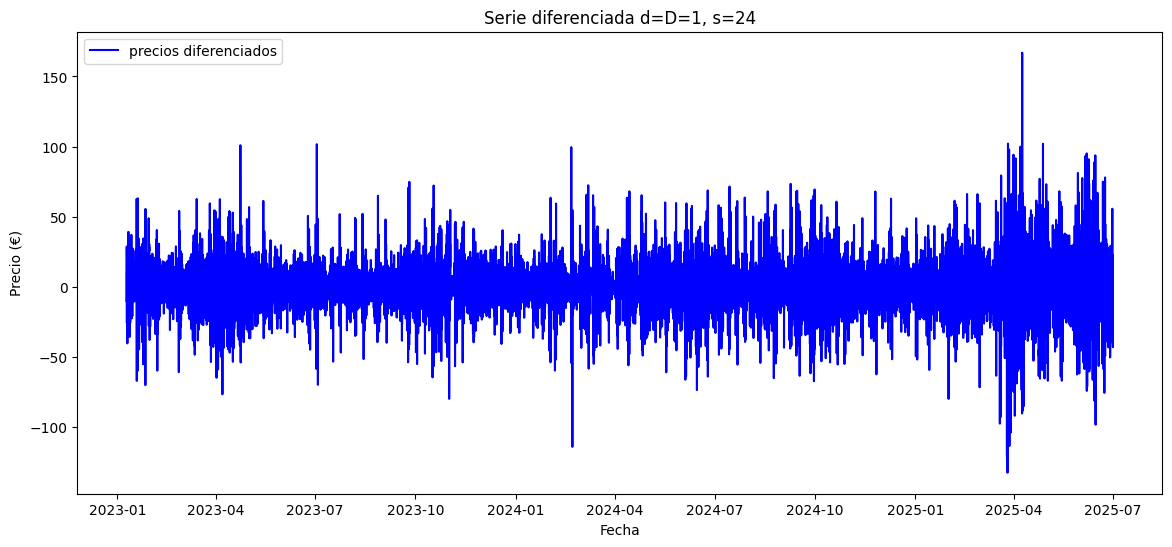

In [12]:
# Una diferenciación d y otra estacional D
df_diferenciada_doble = df['precio'].diff().diff(24).dropna()

# Graficamos la serie diferenciada
plt.figure(figsize=(14,6))
plt.plot(df_diferenciada_doble.index, df_diferenciada_doble,label = 'precios diferenciados', color='blue')
plt.title('Serie diferenciada d=D=1, s=24')
plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.legend()
plt.show()

## Miramos los ACF y PACF de la serie diferenciada d=D=1 (s=24)

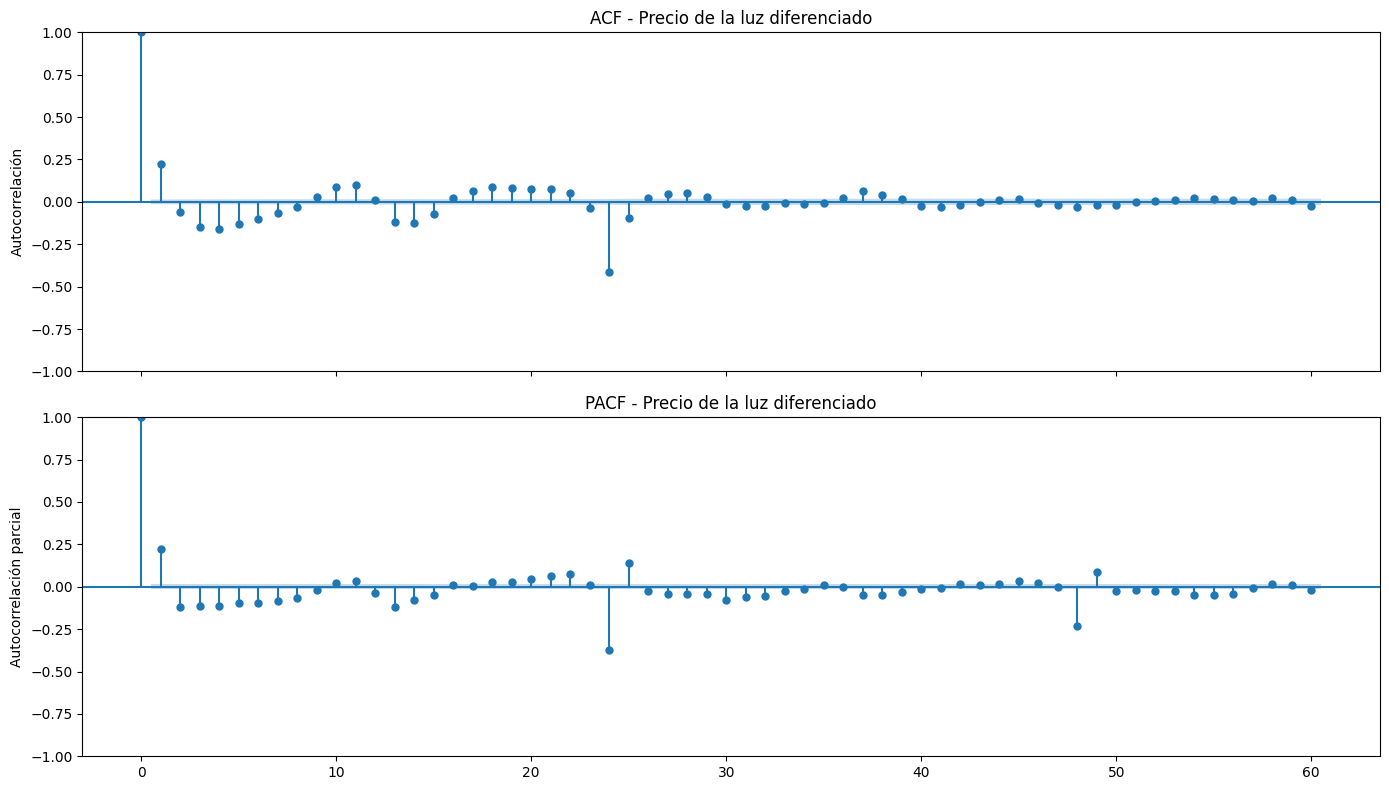

In [13]:
# ACF y PACF de la serie diferenciada
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

plot_acf(df_diferenciada_doble, lags=60, ax=axes[0])
axes[0].set_title('ACF - Precio de la luz diferenciado')
axes[0].set_ylabel('Autocorrelación')

plot_pacf(df_diferenciada_doble, lags=60, ax=axes[1], method='ywm')
axes[1].set_title('PACF - Precio de la luz diferenciado')
axes[1].set_ylabel('Autocorrelación parcial')

plt.tight_layout()
plt.show()

Realizamos el test ADF y KSS para ver como es la serie

- **ADF:** Lo que contrastamos con este test es

    - La hipótesis nula (`H_0`) es que existe una raíz unitaria y por tanto la serie es no estacionaria. (p-valor > `alpha`) 
    - La hipótesis alternativa (`H_a`) de que la serie es estacionaria. (p-valor < `alpha`) 

- **KSS:** En este caso es al revés:
    - La hipótesis nula (`H_0`) es que la serie sí es estacionaria. (p-valor > `alpha`) 
    - La hipótesis alternativa (`H_a`) de que la serie no es estacionaria. (p-valor < `alpha`) 

In [14]:
adf_test = adfuller(df_diferenciada_doble, autolag='AIC')
print(f"p-value: {adf_test[1]}")
kpss_test = kpss(df_diferenciada_doble, regression='c')
print(f"KPSS p-value: {kpss_test[1]}")

p-value: 0.0
KPSS p-value: 0.1


C:\Users\alberto.campuzano\AppData\Local\Temp\ipykernel_11444\221895.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(df_diferenciada_doble, regression='c')


Utilizamos el auto-arima para encontrar la mejor configuración

In [ ]:
modelo_arima = auto_arima(
    y=y_train,
    X=X_train, 
    m=24,           
    start_p=1, max_p=2,
    start_q=0, max_q=1,
    start_P=0, max_P=1,
    start_Q=0, max_Q=1,
    seasonal=True,
    stepwise=True,
    trace=True,
    test='kpss',
    error_action='ignore',
    suppress_warnings=True,
    n_fits=50,
    return_all=False,
    n_jobs=-1,
)

# Resumen del modelo
print(modelo_arima.summary())
print(f"Parámetros SARIMAX: {modelo_arima.get_params()['order']} (ARIMA) y {modelo_arima.get_params()['seasonal_order']} (estacional)")

Los mejores modelos son:

| Rank | Modelo                             | AIC            |
| ---- | ---------------------------------- | -------------- |
| 1  | SARIMAX(2,1,0)(1,0,1,24) |140503.664|  
| 2  | SARIMAX(1,1,1)(1,0,1,24) |140808.352|
| 3  | SARIMAX(0,1,1)(1,0,1,24) |140823.120|             

# (2,1,1)x(1,1,1,24)'

In [19]:
modelo_arima = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(2, 1, 1),
    seasonal_order=(1, 1, 1, 24)
)
modelo_arima_fit = modelo_arima.fit(disp=False)

start_pred = 0
end_pred = len(y_test) - 1

pred_test_obj = modelo_arima_fit.get_prediction(
    start=start_pred, 
    end=end_pred, 
    exog=X_test
)
# Obtenemos las predicciones y sus índices
y_pred_test = pred_test_obj.predicted_mean
y_true_test = y_test
y_pred_test.index = y_test.index

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluamos métricas

In [20]:
print(f"MAE en la predicción: {mean_absolute_error(y_true_test, y_pred_test):.2f}")
print(f"RMSE en la predicción: {root_mean_squared_error(y_true_test, y_pred_test):.2f}")
print(f"R² en la predicción: {r2_score(y_true_test, y_pred_test):.2f}")

MAE en la predicción: 47.26
RMSE en la predicción: 61.64
R² en la predicción: -4.93


## Graficamos

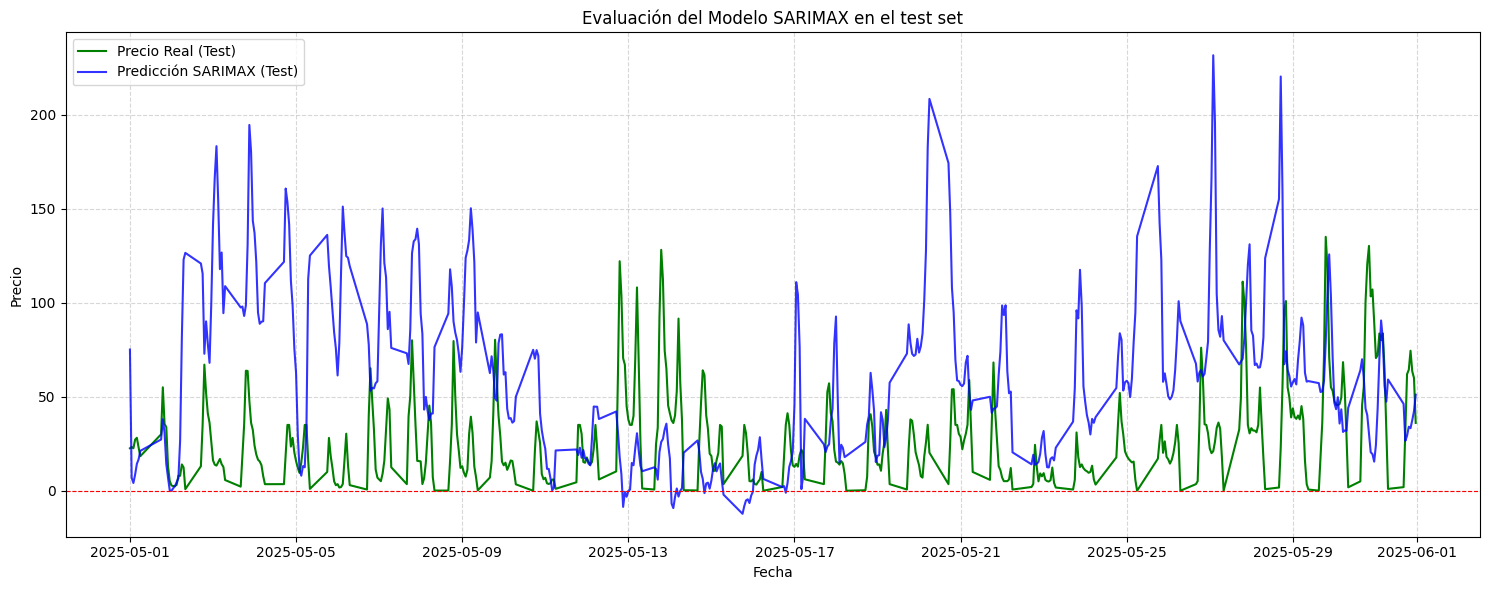

In [21]:
# Gráfico
plt.figure(figsize=(15, 6)) 
plt.plot(y_true_test.index, y_true_test, label='Precio Real (Test)', color='green') 
plt.plot(y_pred_test.index, y_pred_test, label='Predicción SARIMAX (Test)', color='blue', alpha=0.8) 
plt.title("Evaluación del Modelo SARIMAX en el test set") 
plt.xlabel("Fecha") 
plt.ylabel("Precio") 
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout() 
plt.show()

## Errores

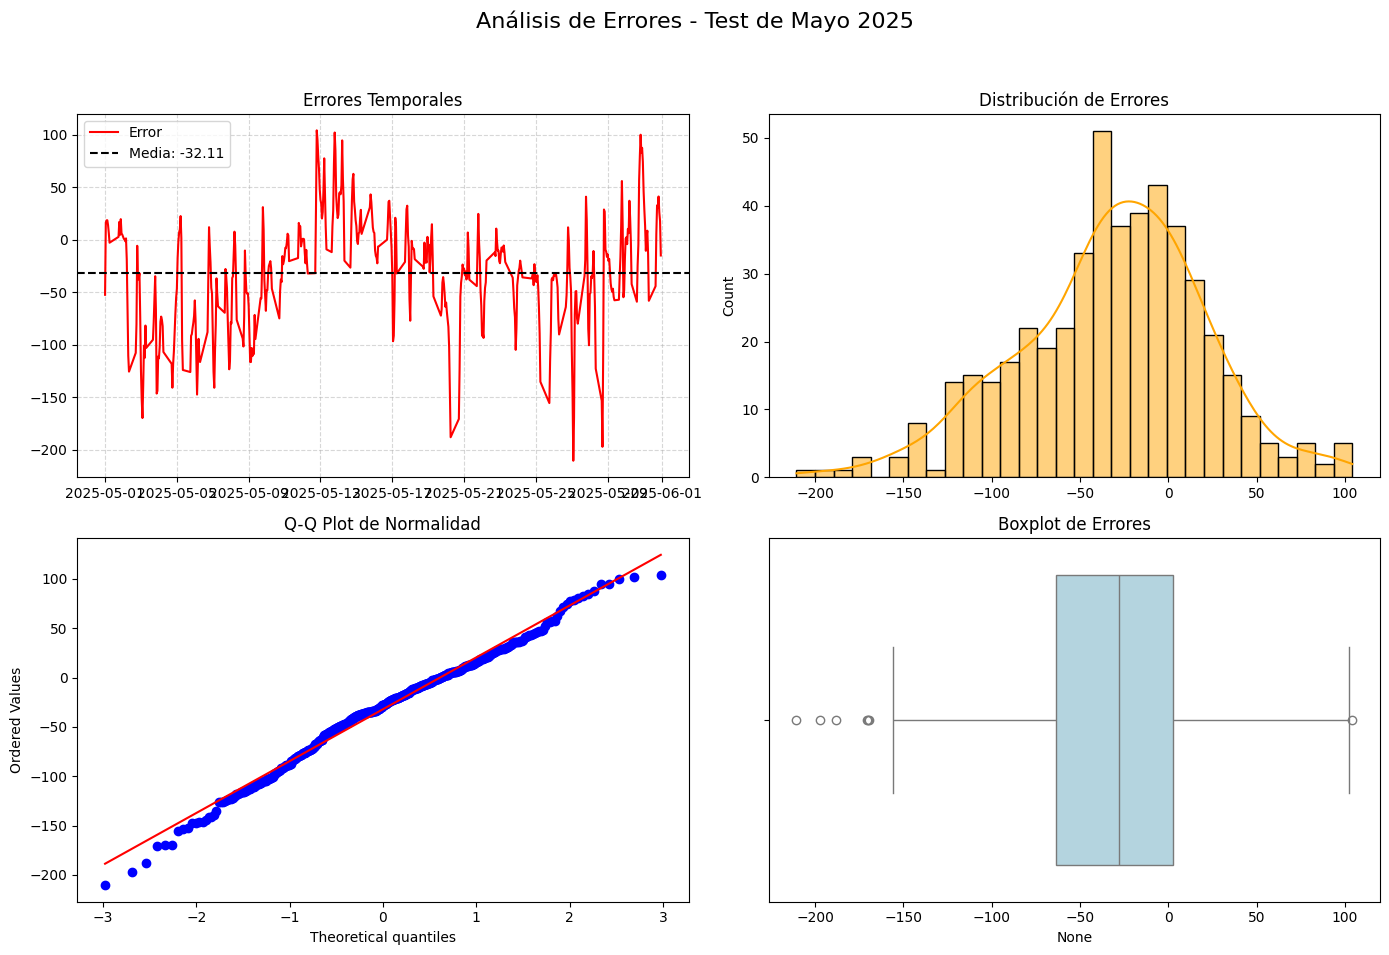

In [22]:
errores_test = y_true_test - y_pred_test
media_err = errores_test.mean()
desv_err = errores_test.std()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Errores - Test de Mayo 2025', fontsize=16)

# Errores a lo largo del tiempo
axs[0, 0].plot(errores_test.index, errores_test, color='red', label='Error')
axs[0, 0].axhline(media_err, ls='--', color='black', label=f'Media: {media_err:.2f}')
axs[0, 0].set_title('Errores Temporales')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# Histograma
sns.histplot(errores_test, bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Distribución de Errores')

# Q-Q Plot
stats.probplot(errores_test, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot de Normalidad')

# Boxplot
sns.boxplot(x=errores_test, ax=axs[1, 1], color='lightblue')
axs[1, 1].set_title('Boxplot de Errores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Prediccion sobre conjunto de validación

In [23]:
y_historico = pd.concat([y_train, y_test])
X_historico = pd.concat([X_train, X_test])

modelo_final = SARIMAX(
    endog=y_historico,
    exog=X_historico,
    order=(2, 1, 1),
    seasonal_order=(1, 1, 1, 24)
)
modelo_final_fit = modelo_final.fit(disp=False)

start_pred = 0
end_pred = len(y_prediccion_real) - 1

# Hacemos la predicción final sobre el conjunto de validación
forecast_future_obj = modelo_final_fit.get_prediction(
    start=start_pred,
    end=end_pred,
    exog=X_prediccion
)

y_pred_val = forecast_future_obj.predicted_mean
y_pred_val.index = y_prediccion_real.index
y_true_val = y_prediccion_real

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intervalos de confianza

In [24]:
residuals = modelo_final_fit.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_fit = garch_model.fit(disp='off')
volatility_forecast = np.sqrt(
    garch_fit.forecast(horizon=len(X_prediccion), reindex=False).variance.values.flatten()
)

# Calcula el intervalo de confianza
conf_int_inf = y_pred_val - 1.96 * volatility_forecast
conf_int_sup = y_pred_val + 1.96 * volatility_forecast

## Evaluación métricas

In [25]:
print(f"MAE en la predicción: {mean_absolute_error(y_true_val, y_pred_val):.2f}")
print(f"RMSE en la predicción: {root_mean_squared_error(y_true_val, y_pred_val):.2f}")
print(f"R² en la predicción: {r2_score(y_true_val, y_pred_val):.2f}")

MAE en la predicción: 54.68
RMSE en la predicción: 66.83
R² en la predicción: -1.07


## Graficamos

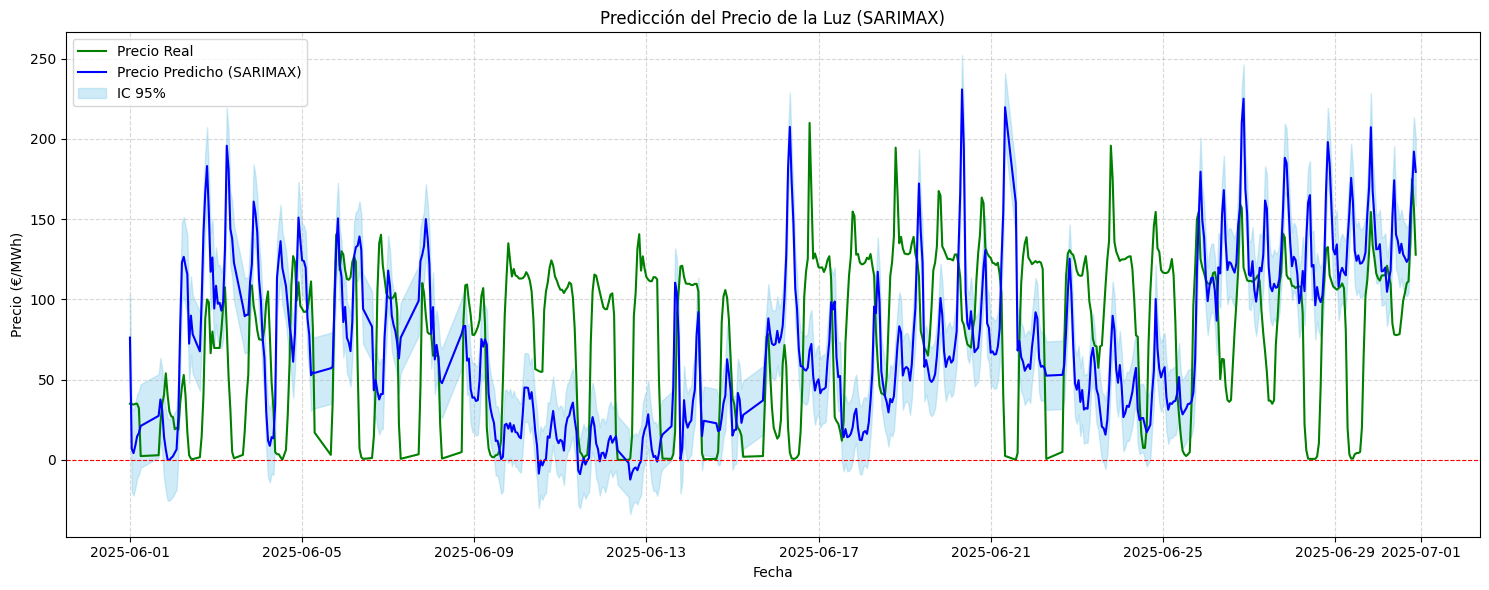

In [26]:
plt.figure(figsize=(15, 6)) 
plt.plot(y_true_val.index, y_true_val, label='Precio Real', color='green') 
plt.plot(y_pred_val.index, y_pred_val, label='Precio Predicho (SARIMAX)', color='blue') 
plt.fill_between( 
    y_true_val.index, conf_int_inf, conf_int_sup, 
    color='skyblue', alpha=0.4, label='IC 95%' 
) 
plt.title("Predicción del Precio de la Luz (SARIMAX)") 
plt.xlabel("Fecha") 
plt.ylabel("Precio (€/MWh)")
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout() 
plt.show()

## Errores

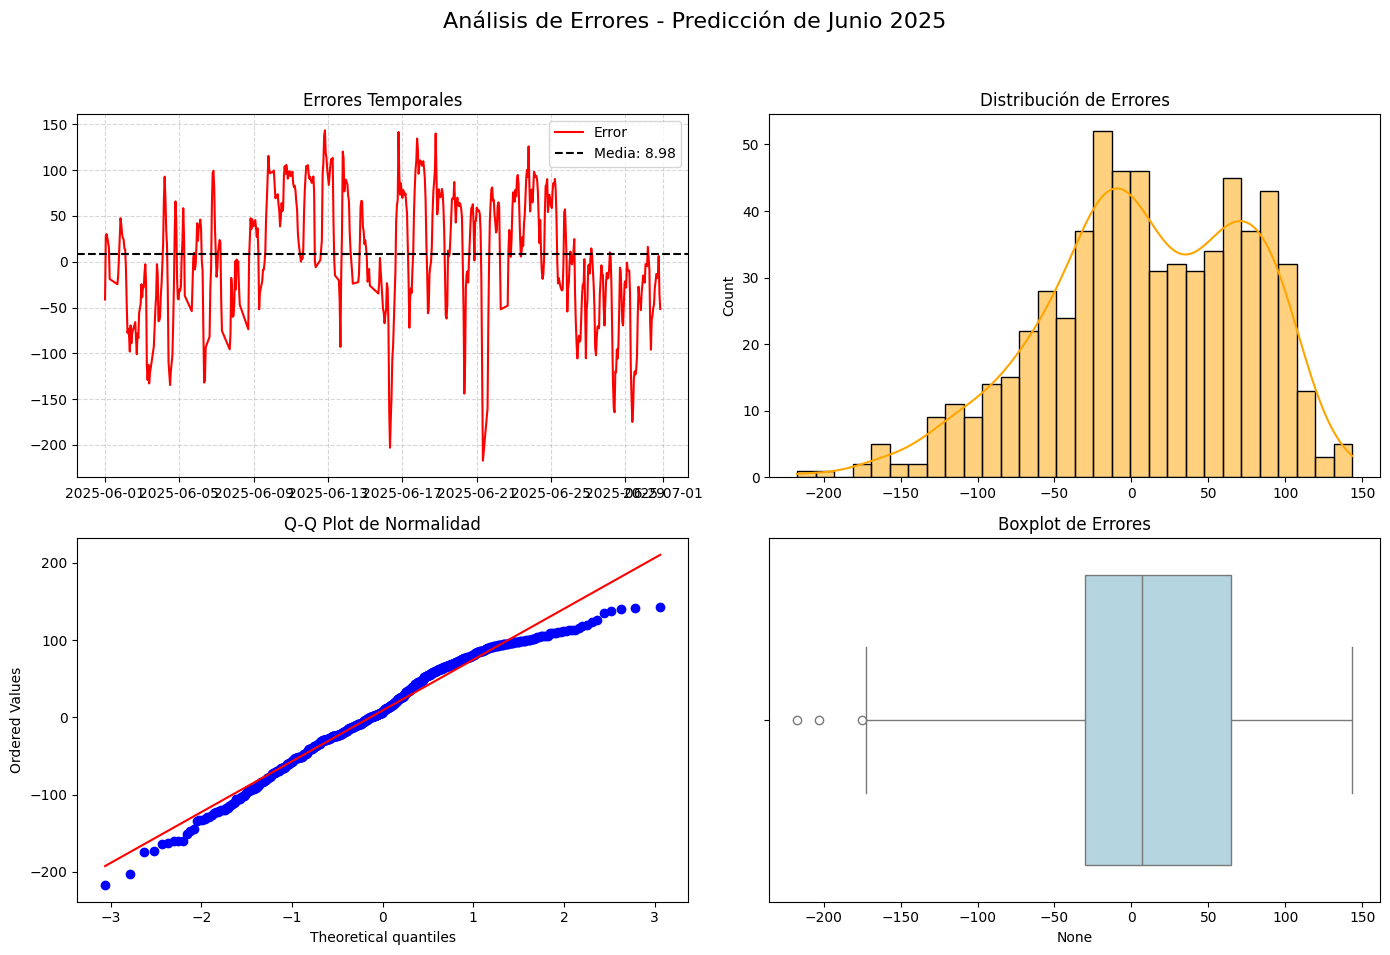

In [27]:
errores_pred = y_true_val - y_pred_val
media_err = errores_pred.mean()
desv_err = errores_pred.std()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Errores - Predicción de Junio 2025', fontsize=16)

# Errores a lo largo del tiempo
axs[0, 0].plot(y_true_val.index, errores_pred, color='red', label='Error')
axs[0, 0].axhline(media_err, ls='--', color='black', label=f'Media: {media_err:.2f}')
axs[0, 0].set_title('Errores Temporales')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# Histograma
sns.histplot(errores_pred, bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Distribución de Errores')

# Q-Q Plot
stats.probplot(errores_pred, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot de Normalidad')

# Boxplot
sns.boxplot(x=errores_pred, ax=axs[1, 1], color='lightblue')
axs[1, 1].set_title('Boxplot de Errores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# (1,1,1)x(1,1,1,24)'

In [28]:
modelo_arima = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24)
)
modelo_arima_fit = modelo_arima.fit(disp=False)

start_pred = 0
end_pred = len(y_test) - 1

pred_test_obj = modelo_arima_fit.get_prediction(
    start=start_pred, 
    end=end_pred, 
    exog=X_test
)
# Obtenemos las predicciones y sus índices
y_pred_test = pred_test_obj.predicted_mean
y_true_test = y_test
y_pred_test.index = y_test.index

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Evaluamos métricas

In [29]:
print(f"MAE en la predicción: {mean_absolute_error(y_true_test, y_pred_test):.2f}")
print(f"RMSE en la predicción: {root_mean_squared_error(y_true_test, y_pred_test):.2f}")
print(f"R² en la predicción: {r2_score(y_true_test, y_pred_test):.2f}")

MAE en la predicción: 47.11
RMSE en la predicción: 61.77
R² en la predicción: -4.96


## Graficamos

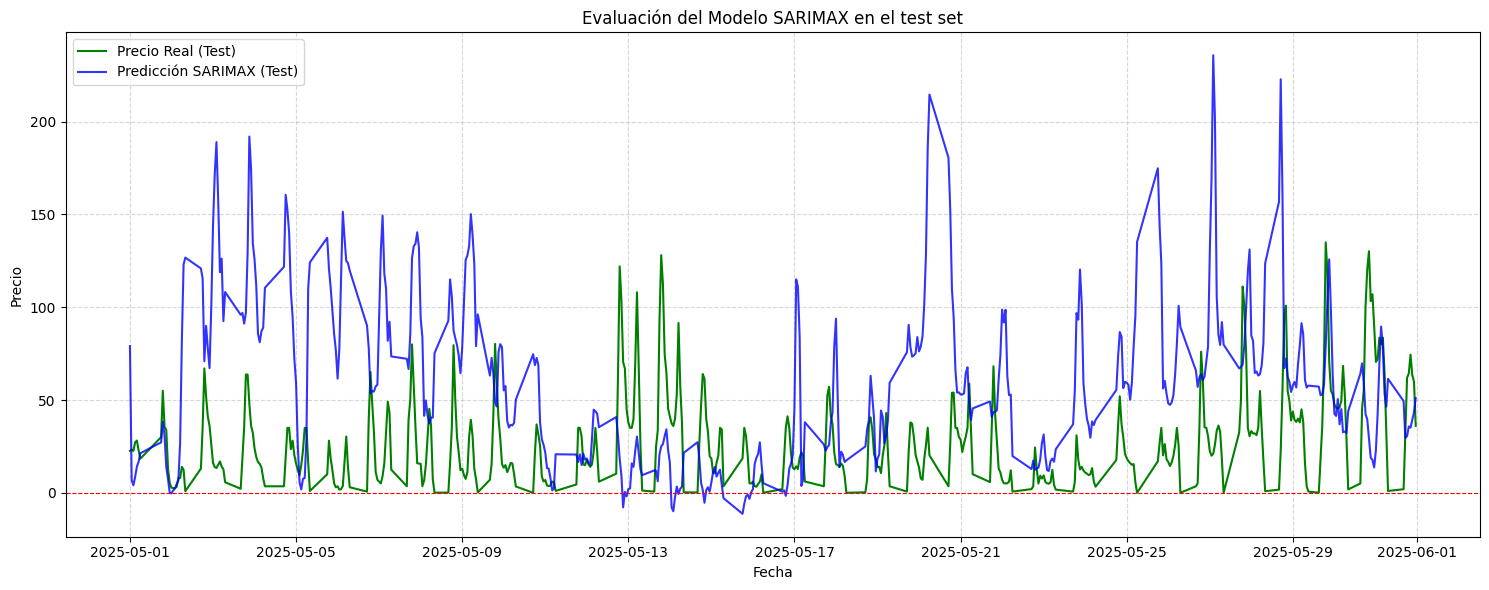

In [30]:
# Gráfico
plt.figure(figsize=(15, 6)) 
plt.plot(y_true_test.index, y_true_test, label='Precio Real (Test)', color='green') 
plt.plot(y_pred_test.index, y_pred_test, label='Predicción SARIMAX (Test)', color='blue', alpha=0.8) 
plt.title("Evaluación del Modelo SARIMAX en el test set") 
plt.xlabel("Fecha") 
plt.ylabel("Precio") 
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout() 
plt.show()

## Errores

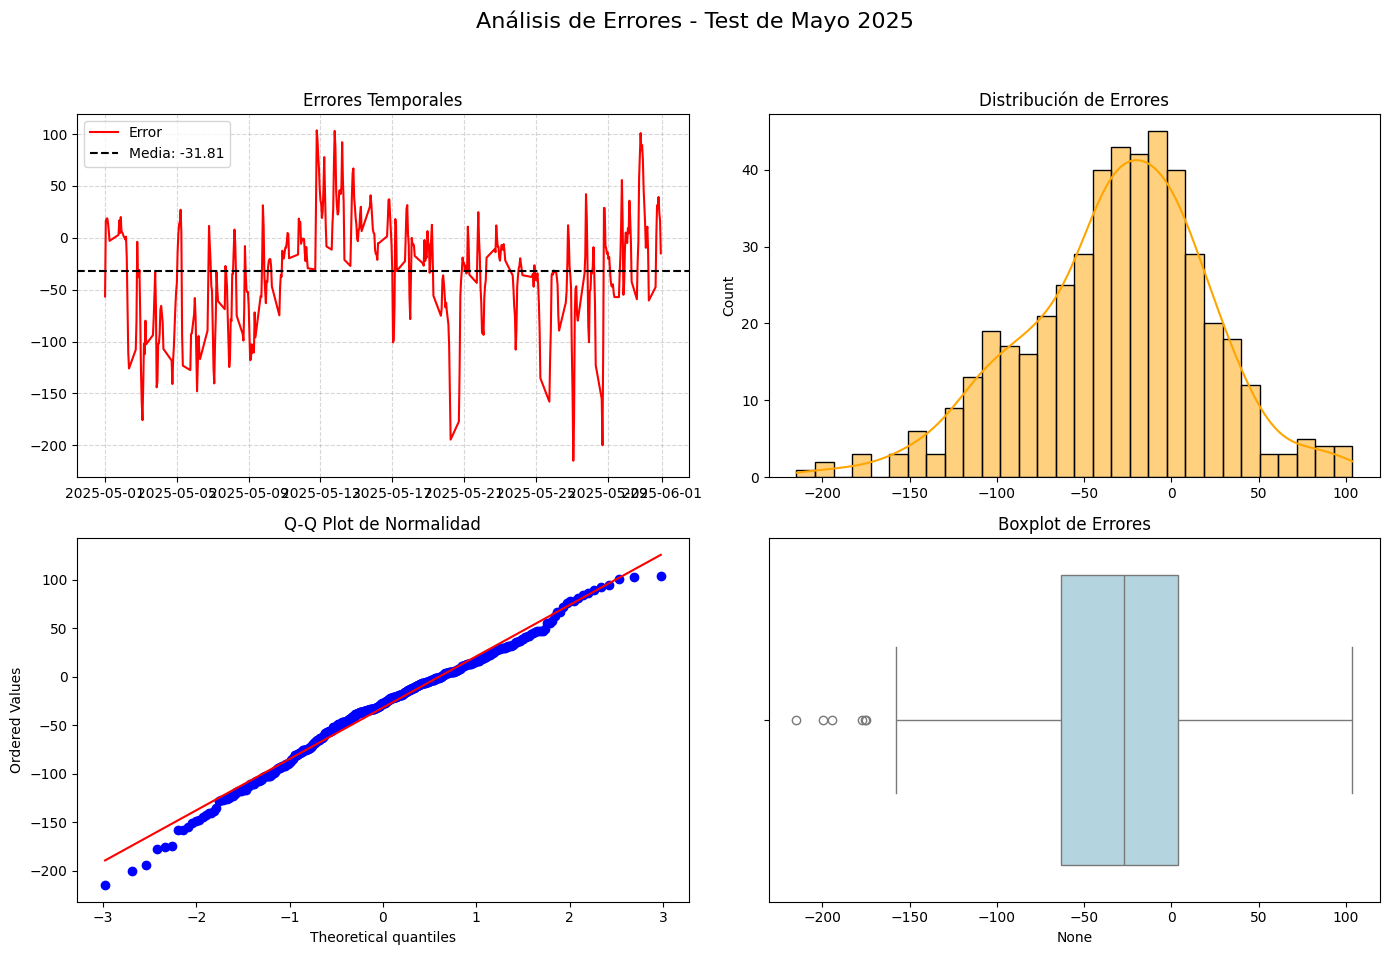

In [31]:
errores_test = y_true_test - y_pred_test
media_err = errores_test.mean()
desv_err = errores_test.std()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Errores - Test de Mayo 2025', fontsize=16)

# Errores a lo largo del tiempo
axs[0, 0].plot(errores_test.index, errores_test, color='red', label='Error')
axs[0, 0].axhline(media_err, ls='--', color='black', label=f'Media: {media_err:.2f}')
axs[0, 0].set_title('Errores Temporales')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# Histograma
sns.histplot(errores_test, bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Distribución de Errores')

# Q-Q Plot
stats.probplot(errores_test, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot de Normalidad')

# Boxplot
sns.boxplot(x=errores_test, ax=axs[1, 1], color='lightblue')
axs[1, 1].set_title('Boxplot de Errores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Prediccion sobre conjunto de validación

In [15]:
# Unimos los datos para reentrenar el modelo
y_historico = pd.concat([y_train, y_test])
X_historico = pd.concat([X_train, X_test])

modelo_final = SARIMAX(
    endog=y_historico,
    exog=X_historico,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 24)
)
modelo_final_fit = modelo_final.fit(disp=False)

start_pred = 0
end_pred = len(y_prediccion_real) - 1

# Hacemos la predicción final sobre el conjunto de validación
forecast_future_obj = modelo_final_fit.get_prediction(
    start=start_pred,
    end=end_pred,
    exog=X_prediccion
)

y_pred_val = forecast_future_obj.predicted_mean
y_pred_val.index = y_prediccion_real.index
y_true_val = y_prediccion_real

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Intervalos de confianza

In [16]:
residuals = modelo_final_fit.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_fit = garch_model.fit(disp='off')
volatility_forecast = np.sqrt(
    garch_fit.forecast(horizon=len(X_prediccion), reindex=False).variance.values.flatten()
)

# Calcula el intervalo de confianza
conf_int_inf = y_pred_val - 1.96 * volatility_forecast
conf_int_sup = y_pred_val + 1.96 * volatility_forecast

## Evaluación métricas

In [17]:
print(f"MAE en la predicción: {mean_absolute_error(y_true_val, y_pred_val):.2f}")
print(f"RMSE en la predicción: {root_mean_squared_error(y_true_val, y_pred_val):.2f}")
print(f"R² en la predicción: {r2_score(y_true_val, y_pred_val):.2f}")

MAE en la predicción: 54.91
RMSE en la predicción: 67.04
R² en la predicción: -1.08


## Graficamos

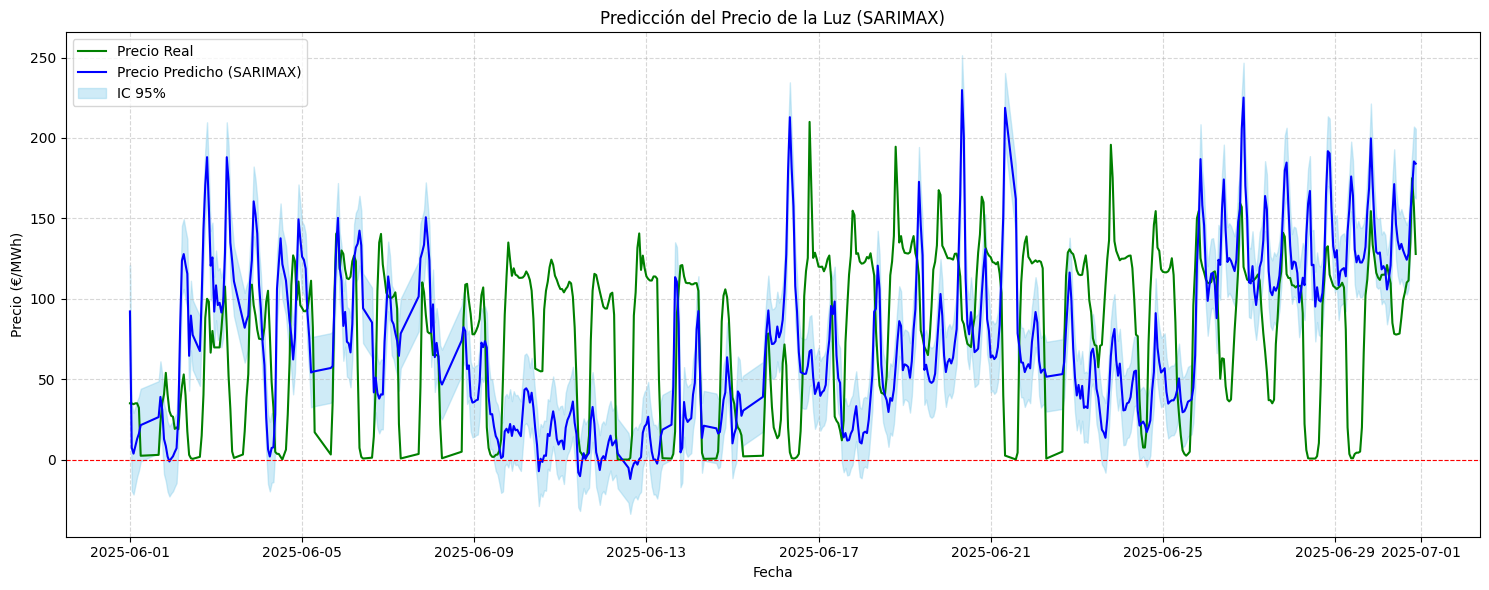

In [18]:
plt.figure(figsize=(15, 6)) 
plt.plot(y_true_val.index, y_true_val, label='Precio Real', color='green') 
plt.plot(y_pred_val.index, y_pred_val, label='Precio Predicho (SARIMAX)', color='blue') 
plt.fill_between( 
    y_true_val.index, conf_int_inf, conf_int_sup, 
    color='skyblue', alpha=0.4, label='IC 95%' 
) 
plt.title("Predicción del Precio de la Luz (SARIMAX)") 
plt.xlabel("Fecha") 
plt.ylabel("Precio (€/MWh)")
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout() 
plt.show()

## Errores

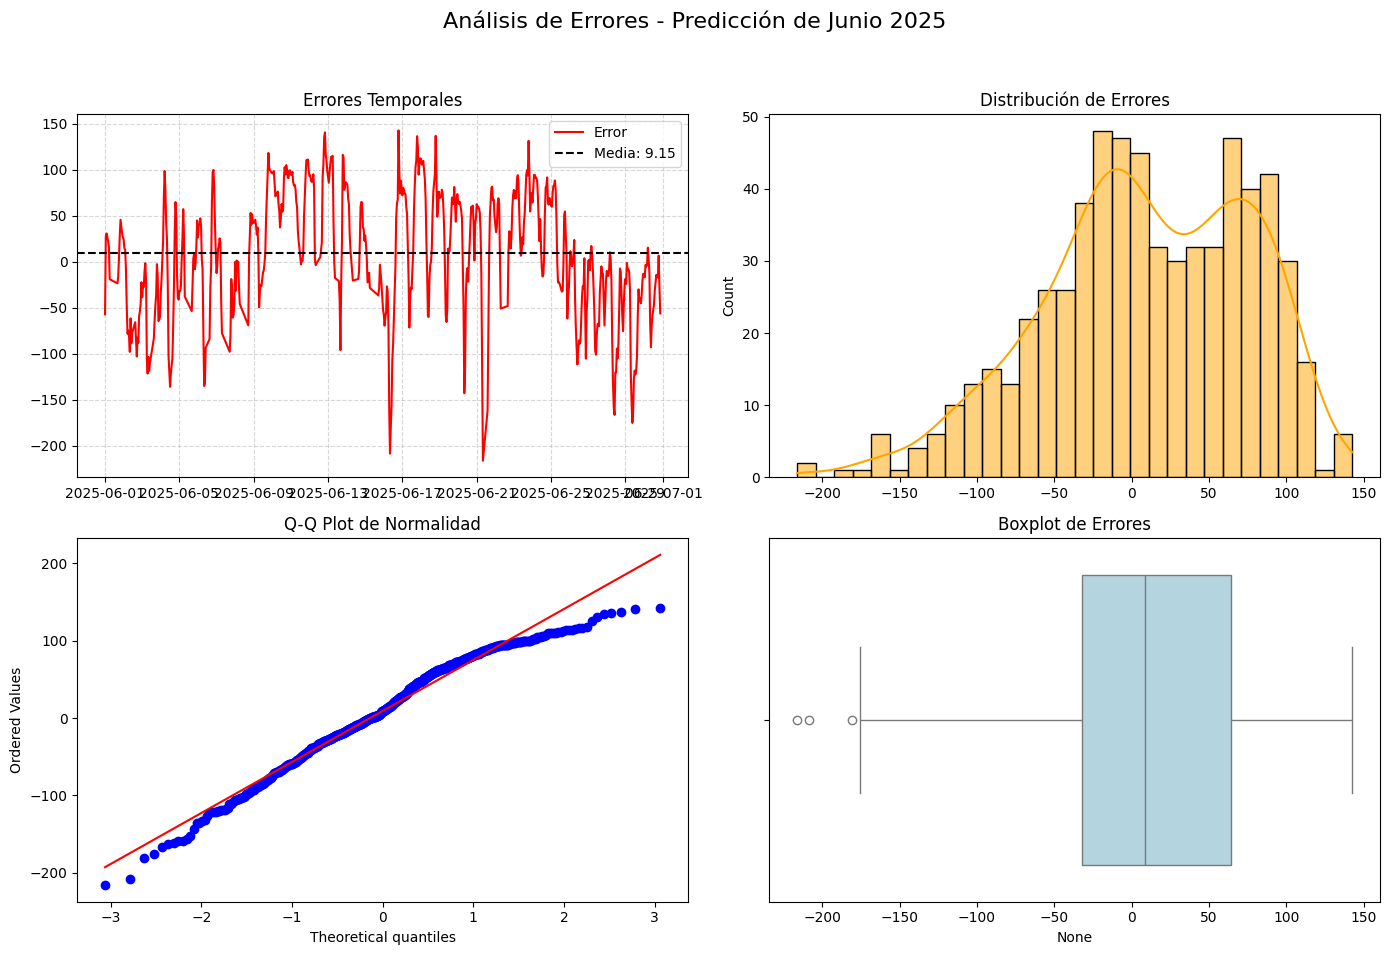

In [19]:
errores_pred = y_true_val - y_pred_val
media_err = errores_pred.mean()
desv_err = errores_pred.std()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Errores - Predicción de Junio 2025', fontsize=16)

# Errores a lo largo del tiempo
axs[0, 0].plot(y_true_val.index, errores_pred, color='red', label='Error')
axs[0, 0].axhline(media_err, ls='--', color='black', label=f'Media: {media_err:.2f}')
axs[0, 0].set_title('Errores Temporales')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# Histograma
sns.histplot(errores_pred, bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Distribución de Errores')

# Q-Q Plot
stats.probplot(errores_pred, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot de Normalidad')

# Boxplot
sns.boxplot(x=errores_pred, ax=axs[1, 1], color='lightblue')
axs[1, 1].set_title('Boxplot de Errores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# (2,1,0)x(1,1,0,24)'

In [20]:
# Usamos SARIMAX directamente con los mejores parámetros que ya conocemos.
modelo_arima = SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(2, 1, 0),
    seasonal_order=(1, 1, 0, 24)
)
modelo_arima_fit = modelo_arima.fit(disp=False)

start_pred = 0
end_pred = len(y_test) - 1

pred_test_obj = modelo_arima_fit.get_prediction(
    start=start_pred, 
    end=end_pred, 
    exog=X_test
)
# Obtenemos las predicciones y sus índices
y_pred_test = pred_test_obj.predicted_mean
y_true_test = y_test
y_pred_test.index = y_test.index

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Evaluamos métricas

In [21]:
print(f"MAE en la predicción: {mean_absolute_error(y_true_test, y_pred_test):.2f}")
print(f"RMSE en la predicción: {root_mean_squared_error(y_true_test, y_pred_test):.2f}")
print(f"R² en la predicción: {r2_score(y_true_test, y_pred_test):.2f}")

MAE en la predicción: 47.30
RMSE en la predicción: 61.99
R² en la predicción: -5.00


## Graficamos

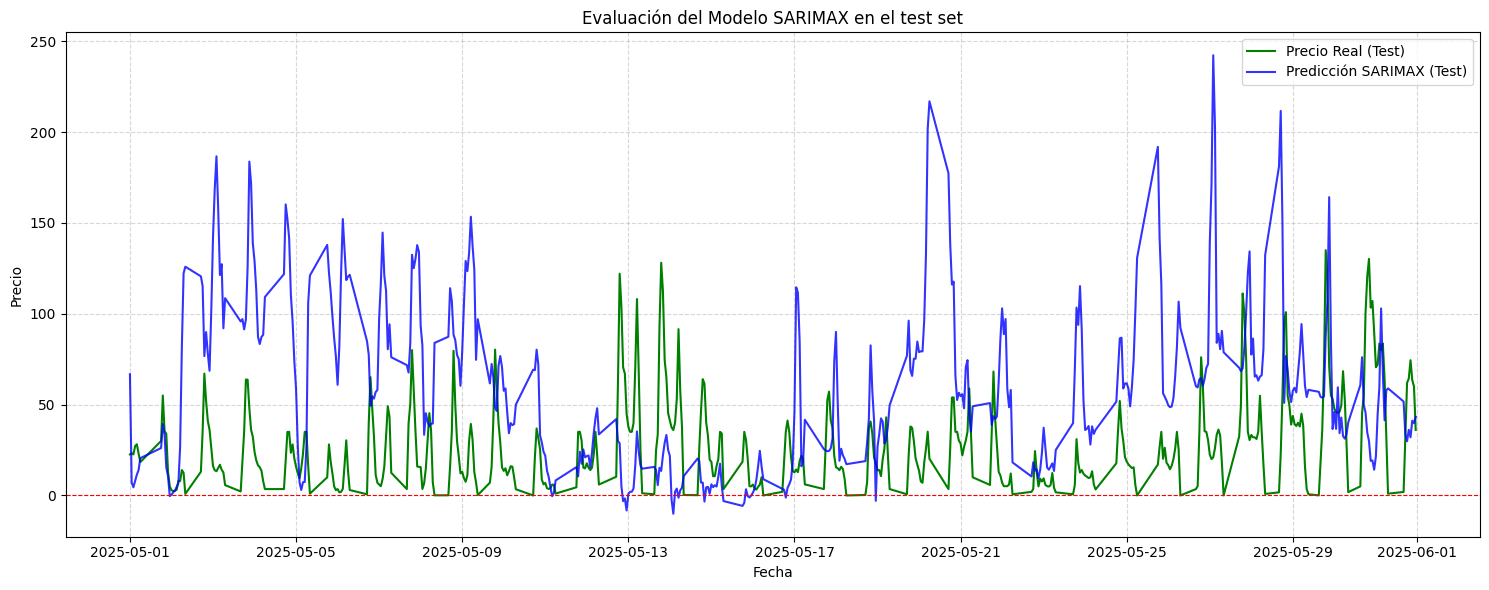

In [22]:
# Gráfico
plt.figure(figsize=(15, 6)) 
plt.plot(y_true_test.index, y_true_test, label='Precio Real (Test)', color='green') 
plt.plot(y_pred_test.index, y_pred_test, label='Predicción SARIMAX (Test)', color='blue', alpha=0.8) 
plt.title("Evaluación del Modelo SARIMAX en el test set") 
plt.xlabel("Fecha") 
plt.ylabel("Precio") 
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.tight_layout() 
plt.show()

## Errores

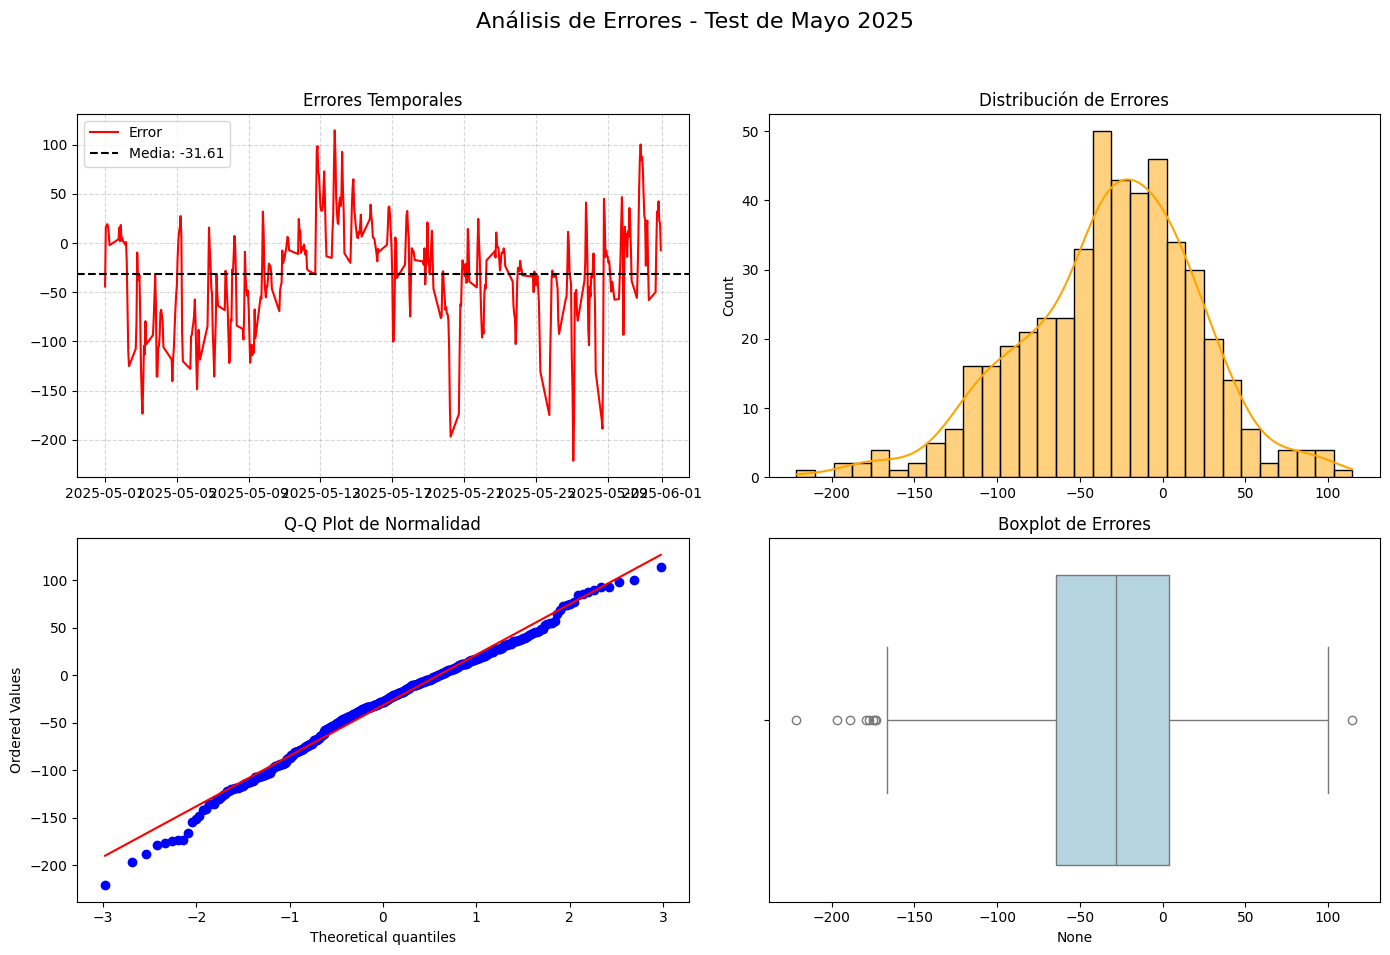

In [23]:
errores_test = y_true_test - y_pred_test
media_err = errores_test.mean()
desv_err = errores_test.std()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Errores - Test de Mayo 2025', fontsize=16)

# Errores a lo largo del tiempo
axs[0, 0].plot(errores_test.index, errores_test, color='red', label='Error')
axs[0, 0].axhline(media_err, ls='--', color='black', label=f'Media: {media_err:.2f}')
axs[0, 0].set_title('Errores Temporales')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# Histograma
sns.histplot(errores_test, bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Distribución de Errores')

# Q-Q Plot
stats.probplot(errores_test, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot de Normalidad')

# Boxplot
sns.boxplot(x=errores_test, ax=axs[1, 1], color='lightblue')
axs[1, 1].set_title('Boxplot de Errores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Prediccion sobre conjunto de validación

In [24]:
# Unimos los datos para reentrenar el modelo
y_historico = pd.concat([y_train, y_test])
X_historico = pd.concat([X_train, X_test])

modelo_final = SARIMAX(
    endog=y_historico,
    exog=X_historico,
    order=(2, 1, 0),
    seasonal_order=(1, 1, 0, 24)
)
modelo_final_fit = modelo_final.fit(disp=False)

start_pred = 0
end_pred = len(y_prediccion_real) - 1

# Hacemos la predicción final sobre el conjunto de validación
forecast_future_obj = modelo_final_fit.get_prediction(
    start=start_pred,
    end=end_pred,
    exog=X_prediccion
)

y_pred_val = forecast_future_obj.predicted_mean
y_pred_val.index = y_prediccion_real.index
y_true_val = y_prediccion_real

c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\alberto.campuzano\Desktop\CasusoPropellers\prediccion-precios-luz\modelos\SARIMAX\env_sarimax\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Intervalos de confianza

In [25]:
residuals = modelo_final_fit.resid

garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_fit = garch_model.fit(disp='off')
volatility_forecast = np.sqrt(
    garch_fit.forecast(horizon=len(X_prediccion), reindex=False).variance.values.flatten()
)

# Calcula el intervalo de confianza
conf_int_inf = y_pred_val - 1.96 * volatility_forecast
conf_int_sup = y_pred_val + 1.96 * volatility_forecast

## Evaluación métricas

In [26]:
print(f"MAE en la predicción: {mean_absolute_error(y_true_val, y_pred_val):.2f}")
print(f"RMSE en la predicción: {root_mean_squared_error(y_true_val, y_pred_val):.2f}")
print(f"R² en la predicción: {r2_score(y_true_val, y_pred_val):.2f}")

MAE en la predicción: 55.25
RMSE en la predicción: 67.55
R² en la predicción: -1.11


## Graficamos

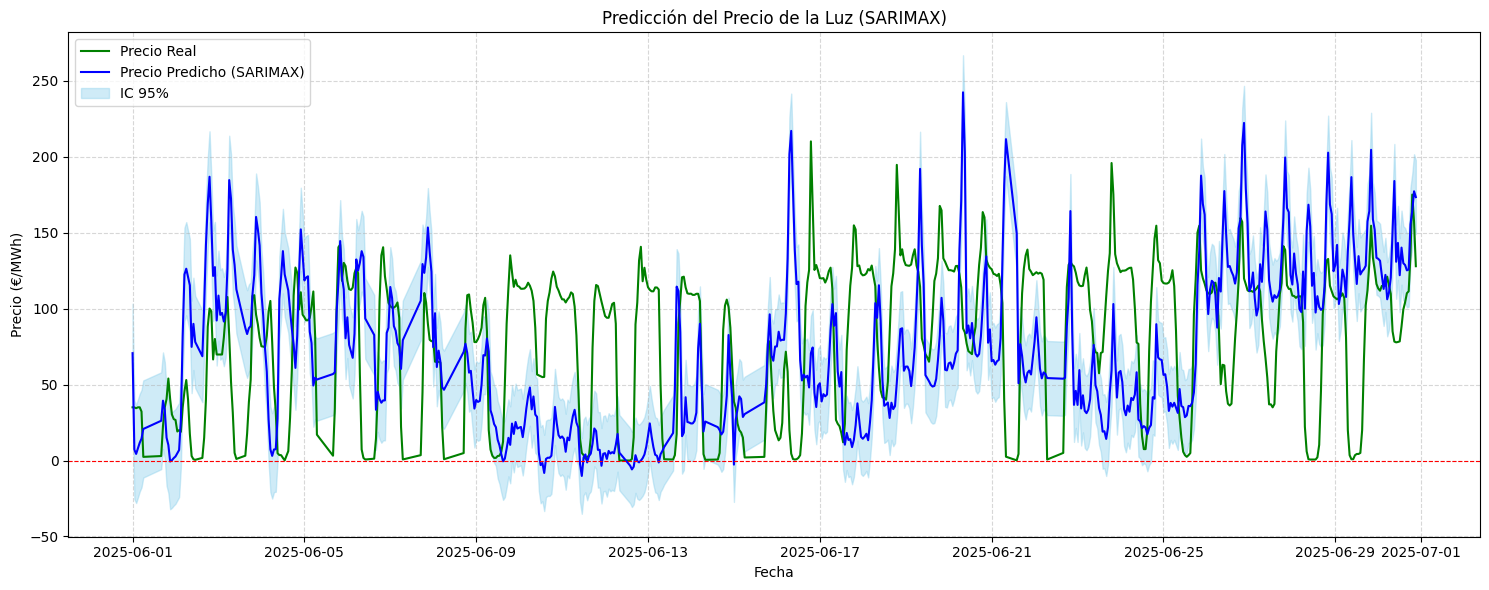

In [27]:
plt.figure(figsize=(15, 6)) 
plt.plot(y_true_val.index, y_true_val, label='Precio Real', color='green') 
plt.plot(y_pred_val.index, y_pred_val, label='Precio Predicho (SARIMAX)', color='blue') 
plt.fill_between( 
    y_true_val.index, conf_int_inf, conf_int_sup, 
    color='skyblue', alpha=0.4, label='IC 95%' 
) 
plt.title("Predicción del Precio de la Luz (SARIMAX)") 
plt.xlabel("Fecha") 
plt.ylabel("Precio (€/MWh)")
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.legend() 
plt.grid(True, linestyle='--', alpha=0.5) 
plt.tight_layout() 
plt.show()

## Errores

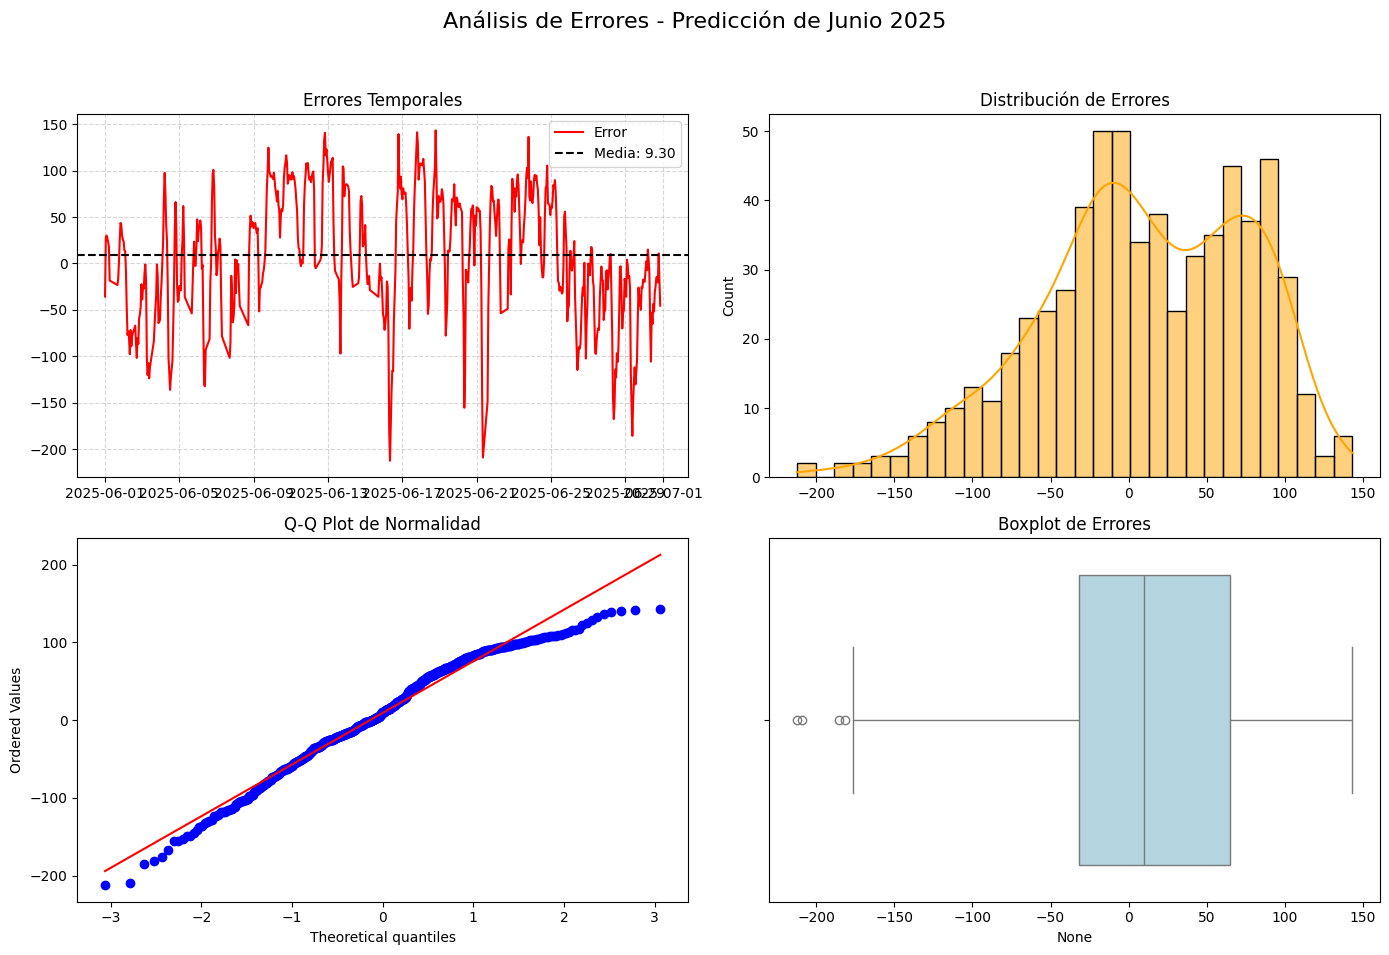

In [28]:
errores_pred = y_true_val - y_pred_val
media_err = errores_pred.mean()
desv_err = errores_pred.std()
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis de Errores - Predicción de Junio 2025', fontsize=16)

# Errores a lo largo del tiempo
axs[0, 0].plot(y_true_val.index, errores_pred, color='red', label='Error')
axs[0, 0].axhline(media_err, ls='--', color='black', label=f'Media: {media_err:.2f}')
axs[0, 0].set_title('Errores Temporales')
axs[0, 0].grid(True, linestyle='--', alpha=0.5)
axs[0, 0].legend()

# Histograma
sns.histplot(errores_pred, bins=30, kde=True, ax=axs[0, 1], color='orange')
axs[0, 1].set_title('Distribución de Errores')

# Q-Q Plot
stats.probplot(errores_pred, dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot de Normalidad')

# Boxplot
sns.boxplot(x=errores_pred, ax=axs[1, 1], color='lightblue')
axs[1, 1].set_title('Boxplot de Errores')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()